# 📚 Case Regulatório MEC/SERES — EDA (2018 – arquivo único)

Este notebook replica as **mesmas análises** do EDA anterior, porém **adaptado às colunas normalizadas** (snake/UPPER) do arquivo anonimizado.

**Objetivos nesta etapa**
- Consolidar e padronizar campos-chave (UF, modalidade, público/privado, âmbito).
- Calcular **tempo de tramitação** (dias) de forma robusta.
- Produzir indicadores e gráficos para apoiar o dashboard (Power BI/Streamlit).
- Focar a análise em **Área CINE Geral** (não a específica).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# (opcional) para modelos exploratórios
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score


## 1) Leitura dos dados (df_1 e df_2)

In [3]:
# Ajuste o nome do arquivo (mesma pasta do notebook)
ARQ_2018 = "total_2019_CINE.xlsx"

df_1 = pd.read_excel(ARQ_2018)

print("df_1:", df_1.shape)
df_1.head()


df_1: (372031, 86)


,ULTIMO_PROCESSO,SITUACAO_DO_PROCESSO,IS_SEDE_EAD,NO_DO_PROCESSO,MODALIDADE,ANO_DO_PROTOCOLO,DATA,ORGAO,ATO,CATEGORIA_ATO,...,CODIGO_CINE_AREA_ESPECIFICA,CINE_AREA_ESPECIFICA,CODIGO_AREA_GERAL_CINE,AREA_GERAL_CINE,CODIGO_AREA_DETALHADA_CINE,AREA_DETALHADA_CINE,CODIGO_AREA_ESPECIFICA_CINE,AREA_ESPECIFICA_CINE,ROTULO_CINE,AVALIACAO_OFICIAL
0,NÃO,Aguardando Pagamento,N,202502594,PRESENCIAL,NaN,NaN,NaN,Renovação de Reconhecimento de Curso,Curso,...,21.0,Artes,2.0,Artes e humanidades,211.0,"Produção audiovisual, de mídia e cultural",21.0,Artes,Produção audiovisual,Regulação
1,NÃO,Aguardando Pagamento,N,202502594,PRESENCIAL,NaN,NaN,NaN,Renovação de Reconhecimento de Curso,Curso,...,21.0,Artes,2.0,Artes e humanidades,211.0,"Produção audiovisual, de mídia e cultural",21.0,Artes,Produção audiovisual,Regulação
2,NÃO,Aguardando Pagamento,N,202504551,PRESENCIAL,NaN,NaN,NaN,Reconhecimento de Curso,Curso,...,42.0,Direito,4.0,"Negócios, administração e direito",421.0,Direito,42.0,Direito,Direito,Regulação
3,NÃO,Aguardando Pagamento,N,202504555,PRESENCIAL,NaN,NaN,NaN,Reconhecimento de Curso,Curso,...,11.0,Educação,1.0,Educação,113.0,Formação de professores sem áreas específicas,11.0,Educação,Pedagogia,Regulação
4,NÃO,Aguardando Pagamento,N,202504576,EAD,NaN,NaN,NaN,Reconhecimento de Curso EAD,Curso,...,41.0,Negócios e administração,4.0,"Negócios, administração e direito",413.0,Gestão e administração,41.0,Negócios e administração,Administração,Regulação


## 2) Funções utilitárias e padronização mínima

In [4]:
def normalize_missing(s: pd.Series) -> pd.Series:
    """Converte vazios/strings de nulo em NaN (sem mexer em números)."""
    x = s.copy()
    x = x.astype(str).str.strip()
    x = x.replace({"": np.nan, "nan": np.nan, "NAN": np.nan, "None": np.nan, "NONE": np.nan})
    return x

def bar_gradient_with_labels(labels, values, title, xlabel, ylabel, horizontal=False, figsize=(10,5)):
    """Bar chart com gradiente + rótulos de dados + sem eixo numérico (padrão do case)."""
    values = np.asarray(values)
    labels = [str(l) for l in labels]

    if len(values) == 0:
        print("⚠️ Sem dados para plotar.")
        return

    vmin, vmax = values.min(), values.max()
    norm = plt.Normalize(vmin - 1, vmax + 1) if vmin == vmax else plt.Normalize(vmin, vmax)
    colors = plt.cm.Blues(norm(values))

    plt.figure(figsize=figsize)

    if horizontal:
        bars = plt.barh(labels, values, color=colors)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

        ax = plt.gca()
        ax.spines["bottom"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.xaxis.set_ticks([])

        for b in bars:
            w = b.get_width()
            plt.text(w, b.get_y() + b.get_height()/2, f"{int(w):,}".replace(",","."), va="center", ha="left", fontsize=9)
        plt.gca().invert_yaxis()  # maior no topo
    else:
        bars = plt.bar(labels, values, color=colors)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

        ax = plt.gca()
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.yaxis.set_ticks([])

        for b in bars:
            h = b.get_height()
            plt.text(b.get_x() + b.get_width()/2, h, f"{int(h):,}".replace(",","."), va="bottom", ha="center", fontsize=9)

    plt.tight_layout()
    plt.show()

def preparar_base(df: pd.DataFrame) -> pd.DataFrame:
    """Ajustes mínimos para o EDA conforme layout atual."""
    out = df.copy()

    # (1) Remover coluna NO_DO_PROCESSO se existir (pedido)
    if "NO_DO_PROCESSO" in out.columns:
        out = out.drop(columns=["NO_DO_PROCESSO"])

    # (2) Padronizar Área CINE Geral e preencher vazios
    # Colunas esperadas: AREA_GERAL_CINE, CODIGO_AREA_GERAL_CINE
    if "AREA_GERAL_CINE" in out.columns:
        out["AREA_GERAL_CINE"] = normalize_missing(out["AREA_GERAL_CINE"]).fillna("Não informado")
    else:
        out["AREA_GERAL_CINE"] = "Não informado"

    if "CODIGO_AREA_GERAL_CINE" in out.columns:
        out["CODIGO_AREA_GERAL_CINE"] = normalize_missing(out["CODIGO_AREA_GERAL_CINE"]).fillna("Não informado")
    else:
        out["CODIGO_AREA_GERAL_CINE"] = "Não informado"

    # (3) UF: preferir UF_PROCESSO, senão UF_CADASTRO
    if "UF_PROCESSO" in out.columns:
        out["UF"] = normalize_missing(out["UF_PROCESSO"])
    elif "UF_CADASTRO" in out.columns:
        out["UF"] = normalize_missing(out["UF_CADASTRO"])
    else:
        out["UF"] = np.nan

    # (4) Ano do protocolo numérico
    if "ANO_DO_PROTOCOLO" in out.columns:
        out["ANO_DO_PROTOCOLO"] = pd.to_numeric(out["ANO_DO_PROTOCOLO"], errors="coerce")

    # (5) Modalidade normalizada
    if "MODALIDADE" in out.columns:
        out["MODALIDADE_NORM"] = normalize_missing(out["MODALIDADE"]).str.upper()
    else:
        out["MODALIDADE_NORM"] = np.nan

    # (6) Pública vs Privada (heurística por categoria administrativa)
    if "CATEGORIA_ADMINISTRATIVA" in out.columns:
        cat = normalize_missing(out["CATEGORIA_ADMINISTRATIVA"]).str.upper()
        out["PUBLICA_PRIVADA"] = np.where(cat.str.contains("PÚBLIC|PUBLIC", na=False), "PÚBLICA", "PRIVADA")
    else:
        out["PUBLICA_PRIVADA"] = np.nan

    # (7) Âmbito administrativo (já existe SISTEMA_DE_ENSINO)
    if "SISTEMA_DE_ENSINO" in out.columns:
        sist = normalize_missing(out["SISTEMA_DE_ENSINO"]).str.upper()
        out["AMBITO_ADMINISTRATIVO"] = np.select(
            [
                sist.str.contains("FEDERAL", na=False),
                sist.str.contains("ESTADUAL", na=False),
                sist.str.contains("MUNICIPAL", na=False),
            ],
            ["FEDERAL", "ESTADUAL", "MUNICIPAL"],
            default="OUTROS"
        )
    else:
        out["AMBITO_ADMINISTRATIVO"] = "DESCONHECIDO"

    # (8) Datas e tempo de tramitação
    # Regra: início = DATA (protocolo); fim = DATA_DE_ENTRADA_FASE_ATUAL (preferência), senão DATA_DO_ULTIMO_ATO
    if "DATA" in out.columns:
        out["DATA"] = pd.to_datetime(out["DATA"], errors="coerce")

    fim_col = None
    if "DATA_DE_ENTRADA_FASE_ATUAL" in out.columns:
        out["DATA_DE_ENTRADA_FASE_ATUAL"] = pd.to_datetime(out["DATA_DE_ENTRADA_FASE_ATUAL"], errors="coerce")
        fim_col = "DATA_DE_ENTRADA_FASE_ATUAL"
    elif "DATA_DO_ULTIMO_ATO" in out.columns:
        out["DATA_DO_ULTIMO_ATO"] = pd.to_datetime(out["DATA_DO_ULTIMO_ATO"], errors="coerce")
        fim_col = "DATA_DO_ULTIMO_ATO"

    if ("DATA" in out.columns) and (fim_col is not None):
        out["TEMPO_TRAMITACAO_DIAS"] = (out[fim_col] - out["DATA"]).dt.days
        # limpar negativos e zeros (zero pode existir, mas costuma ser ruído)
        out.loc[out["TEMPO_TRAMITACAO_DIAS"] < 0, "TEMPO_TRAMITACAO_DIAS"] = np.nan
    else:
        out["TEMPO_TRAMITACAO_DIAS"] = np.nan

    # (9) Divergência de vagas
    if {"VAGAS_SOLICITADAS_PROCESSO", "VAGAS_AUTORIZADAS_CADASTRO"}.issubset(out.columns):
        vs = pd.to_numeric(out["VAGAS_SOLICITADAS_PROCESSO"], errors="coerce").fillna(0)
        va = pd.to_numeric(out["VAGAS_AUTORIZADAS_CADASTRO"], errors="coerce").fillna(0)
        out["DIF_VAGAS_PROCESSO_CADASTRO"] = vs - va
        out["TEM_DIVERGENCIA_VAGAS"] = (out["DIF_VAGAS_PROCESSO_CADASTRO"] != 0).astype(int)
    else:
        out["DIF_VAGAS_PROCESSO_CADASTRO"] = np.nan
        out["TEM_DIVERGENCIA_VAGAS"] = np.nan

    return out


In [5]:
df_1 = preparar_base(df_1)

df_1[[c for c in [
    "ANO_DO_PROTOCOLO","UF","MODALIDADE_NORM","PUBLICA_PRIVADA","AMBITO_ADMINISTRATIVO",
    "AREA_GERAL_CINE","TEMPO_TRAMITACAO_DIAS"
] if c in df_1.columns]].head()


C:\Users\LeaoN\AppData\Local\Temp\ipykernel_25332\57424049.py:125: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  out["DATA_DE_ENTRADA_FASE_ATUAL"] = pd.to_datetime(out["DATA_DE_ENTRADA_FASE_ATUAL"], errors="coerce")


,ANO_DO_PROTOCOLO,UF,MODALIDADE_NORM,PUBLICA_PRIVADA,AMBITO_ADMINISTRATIVO,AREA_GERAL_CINE,TEMPO_TRAMITACAO_DIAS
0,NaN,PR,PRESENCIAL,PRIVADA,FEDERAL,Artes e humanidades,NaN
1,NaN,PR,PRESENCIAL,PRIVADA,FEDERAL,Artes e humanidades,NaN
2,NaN,RS,PRESENCIAL,PRIVADA,FEDERAL,"Negócios, administração e direito",NaN
3,NaN,PB,PRESENCIAL,PRIVADA,FEDERAL,Educação,NaN
4,NaN,PE,EAD,PRIVADA,FEDERAL,"Negócios, administração e direito",NaN


## 3) Volume de processos por ano de protocolo

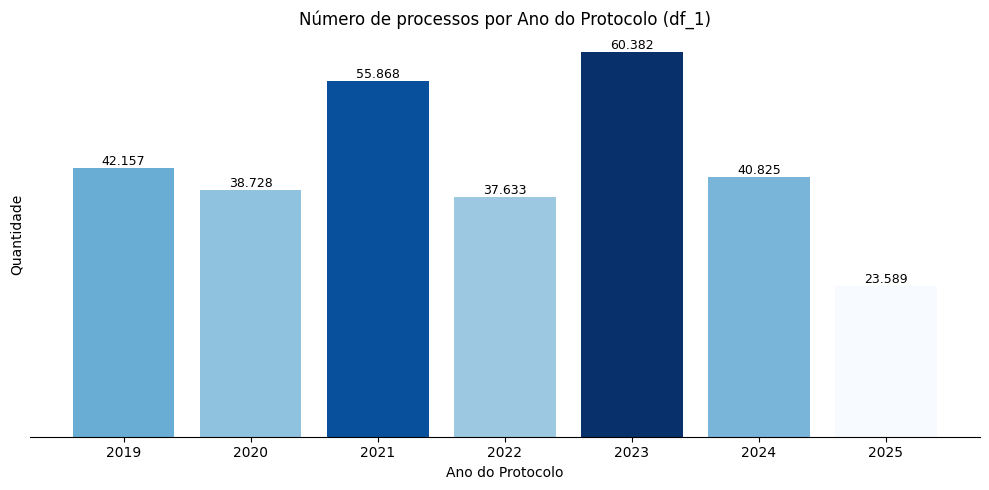

In [6]:
proc_por_ano = df_1.groupby("ANO_DO_PROTOCOLO").size().sort_index()
proc_por_ano = proc_por_ano[proc_por_ano.index.notna()]  # remove NaN de ano

bar_gradient_with_labels(
    labels=proc_por_ano.index.astype(int).astype(str),
    values=proc_por_ano.values,
    title="Número de processos por Ano do Protocolo (df_1)",
    xlabel="Ano do Protocolo",
    ylabel="Quantidade",
    horizontal=False,
    figsize=(10,5)
)


## 4) Tempo médio de tramitação por UF (Top 15)

In [7]:
tempo_uf = (
    df_1.dropna(subset=["UF", "TEMPO_TRAMITACAO_DIAS"])
    .groupby("UF")["TEMPO_TRAMITACAO_DIAS"]
    .agg(media="mean", mediana="median", n="count")
    .sort_values("media", ascending=False)
)

tempo_uf.head(10)


,media,mediana,n
UF,,,
AP,214.155488,0.0,984
DF,193.378790,0.0,6761
RO,189.905878,0.0,3028
RS,186.041657,0.0,17332
GO,182.648732,0.0,10334
PB,182.109969,0.0,4574
MT,175.891694,0.0,6297
PE,174.290312,0.0,9073
SP,169.117763,0.0,66201


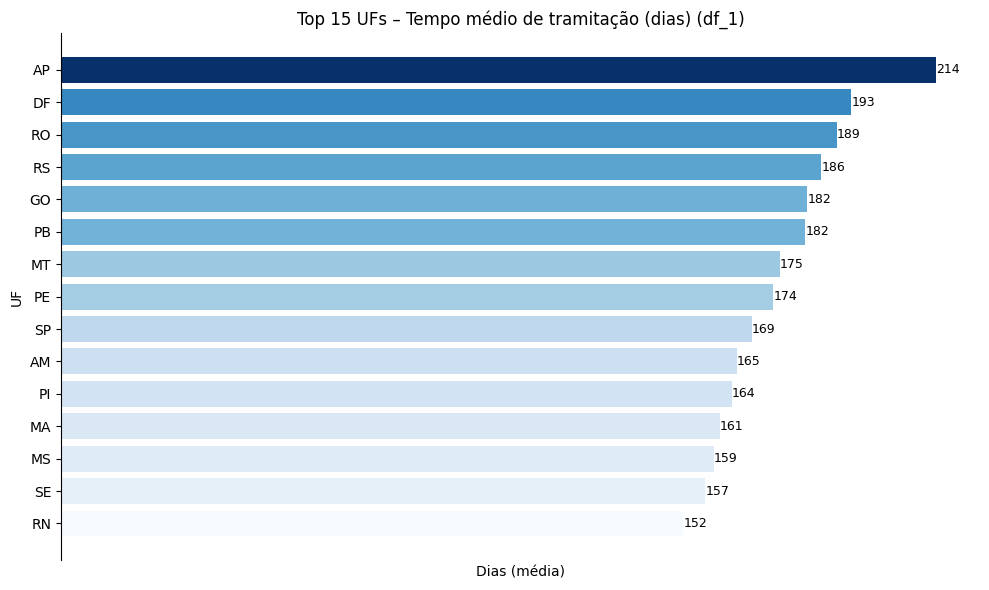

In [8]:
top = tempo_uf["media"].sort_values(ascending=False).head(15)

bar_gradient_with_labels(
    labels=top.index,
    values=top.values,
    title="Top 15 UFs – Tempo médio de tramitação (dias) (df_1)",
    xlabel="Dias (média)",
    ylabel="UF",
    horizontal=True,
    figsize=(10,6)
)


## 5) Resultado do processo (proxy)

⚠️ Importante: este dataset não permite inferir o deferimento real com 100% de certeza.  
Aqui usamos uma **heurística mínima** baseada em:
- `SITUACAO_DO_PROCESSO` contém “CONCLUÍDO”
- e `FASE_ATUAL` contém um dos movimentos típicos de finalização/publicação

Caso contrário, classificamos como “INDEFERIDO (proxy)” apenas para **separação exploratória**.


In [9]:
mov_finalizacao = [
    "SECRETARIA - PARECER FINAL",
    "PARECER FINAL PÓS PROTOCOLO DE COMPROMISSO",
    "SECRETARIA - PARECER FINAL PÓS-RECURSO",
    "PUBLICAÇÃO DA DECISÃO",
    "FINALIZAÇÃO NO SISTEMA - PÓS PUBLICAÇÃO PORTARIA",
]

sit = normalize_missing(df_1["SITUACAO_DO_PROCESSO"]).str.upper() if "SITUACAO_DO_PROCESSO" in df_1.columns else pd.Series([np.nan]*len(df_1))
fase = normalize_missing(df_1["FASE_ATUAL"]).str.upper() if "FASE_ATUAL" in df_1.columns else pd.Series([np.nan]*len(df_1))

is_concluido = sit.str.contains("CONCLU", na=False)
fase_final = fase.apply(lambda x: any(m in x for m in mov_finalizacao) if isinstance(x, str) else False)

df_1["RESULTADO_PROXY"] = np.select(
    [is_concluido & fase_final, is_concluido & (~fase_final)],
    ["DEFERIDO (proxy)", "INDEFERIDO (proxy)"],
    default="EM TRAMITAÇÃO / OUTROS"
)

resultado_pct = (df_1["RESULTADO_PROXY"].value_counts(normalize=True) * 100).round(2)
resultado_pct


RESULTADO_PROXY
INDEFERIDO (proxy)        67.43
EM TRAMITAÇÃO / OUTROS    32.38
DEFERIDO (proxy)           0.18
Name: proportion, dtype: float64

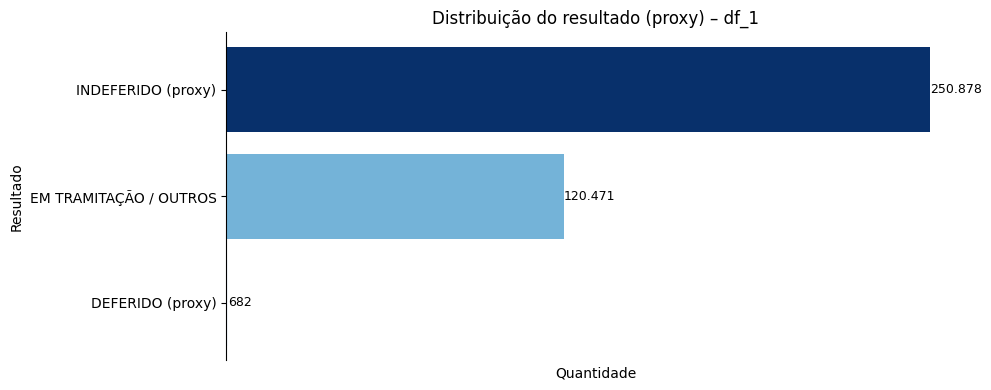

In [10]:
# Gráfico (padrão gradiente + rótulos)
res = df_1["RESULTADO_PROXY"].value_counts()

bar_gradient_with_labels(
    labels=res.index,
    values=res.values,
    title="Distribuição do resultado (proxy) – df_1",
    xlabel="Quantidade",
    ylabel="Resultado",
    horizontal=True,
    figsize=(10,4)
)


## 6) Top 15 – Volume por tipo de Ato

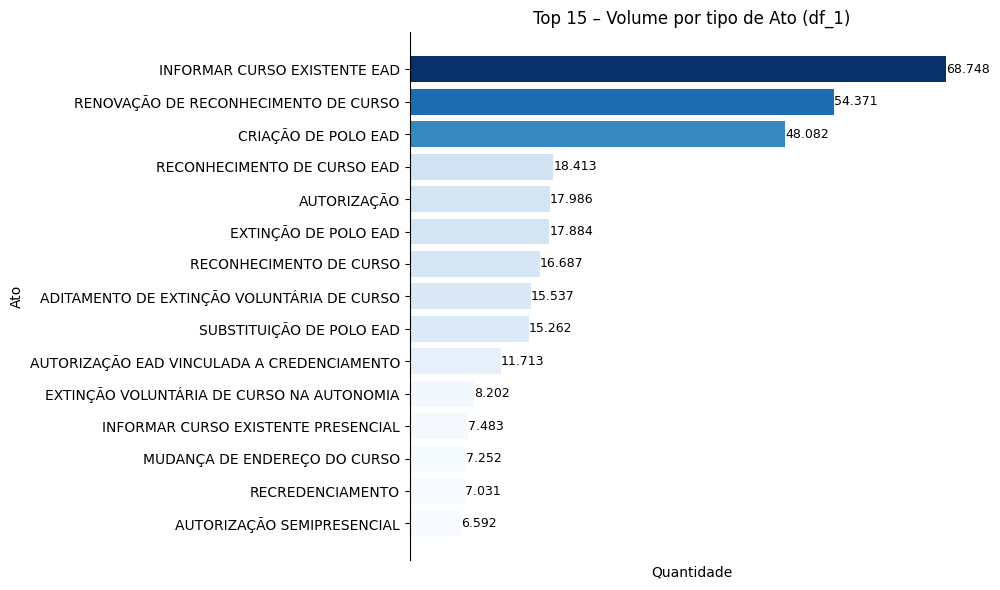

In [11]:
if "ATO" in df_1.columns:
    atos = normalize_missing(df_1["ATO"]).str.upper().dropna().value_counts().head(15)
    bar_gradient_with_labels(
        labels=atos.index,
        values=atos.values,
        title="Top 15 – Volume por tipo de Ato (df_1)",
        xlabel="Quantidade",
        ylabel="Ato",
        horizontal=True,
        figsize=(10,6)
    )
else:
    print("⚠️ Coluna ATO não encontrada.")


## 7) Top 15 – Distribuição por Área CINE (Geral)

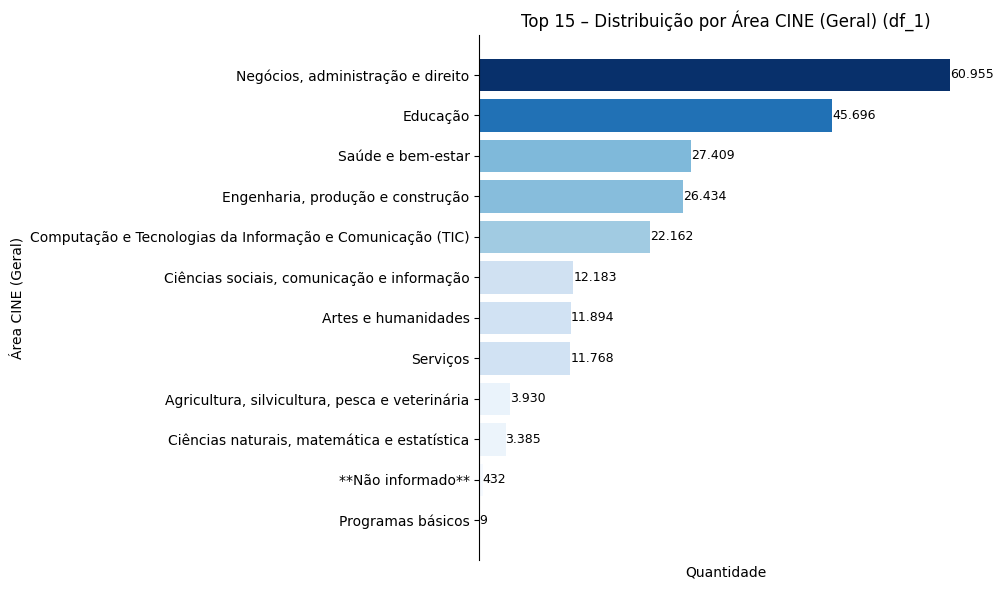

In [12]:
cine = (
    normalize_missing(df_1["AREA_GERAL_CINE"])
    .fillna("Não informado")
    .value_counts()
    .head(15)
)

# (opcional) remova a linha abaixo se quiser manter "Não informado" no top
cine = cine[cine.index != "Não informado"]

bar_gradient_with_labels(
    labels=cine.index,
    values=cine.values,
    title="Top 15 – Distribuição por Área CINE (Geral) (df_1)",
    xlabel="Quantidade",
    ylabel="Área CINE (Geral)",
    horizontal=True,
    figsize=(10,6)
)


## 8) Top 15 – Áreas CINE por carga regulatória (tempo total de tramitação)

In [13]:
sub = df_1.dropna(subset=["AREA_GERAL_CINE", "TEMPO_TRAMITACAO_DIAS"]).copy()
sub = sub[sub["TEMPO_TRAMITACAO_DIAS"] > 0]  # remove tempos zerados

tempo_cine = (
    sub.groupby("AREA_GERAL_CINE")["TEMPO_TRAMITACAO_DIAS"]
    .agg(tempo_medio_dias="mean", tempo_total_dias="sum", n="count")
    .sort_values("tempo_total_dias", ascending=False)
)

tempo_cine.head(10)


,tempo_medio_dias,tempo_total_dias,n
AREA_GERAL_CINE,,,
"Negócios, administração e direito",540.067717,9737961.0,18031
Não informado,653.772642,9434593.0,14431
Educação,492.494040,6486639.0,13171
Saúde e bem-estar,624.445408,5541953.0,8875
"Engenharia, produção e construção",590.270438,4852023.0,8220
Computação e Tecnologias da Informação e Comunicação (TIC),588.798919,3159495.0,5366
Artes e humanidades,648.801325,2155318.0,3322
"Ciências sociais, comunicação e informação",579.528107,1958805.0,3380
Serviços,552.828826,1553449.0,2810


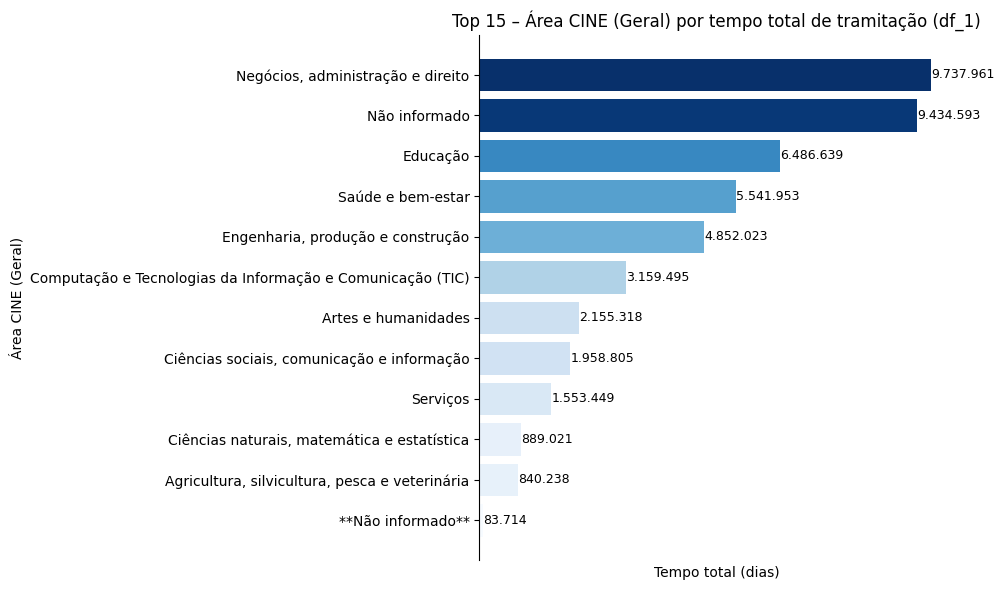

In [14]:
top_cine = tempo_cine.head(15)

bar_gradient_with_labels(
    labels=top_cine.index,
    values=top_cine["tempo_total_dias"].values,
    title="Top 15 – Área CINE (Geral) por tempo total de tramitação (df_1)",
    xlabel="Tempo total (dias)",
    ylabel="Área CINE (Geral)",
    horizontal=True,
    figsize=(10,6)
)


## 9) Pública vs Privada — volume e tempo

In [15]:
tempo_pub_priv = (
    df_1.dropna(subset=["PUBLICA_PRIVADA", "TEMPO_TRAMITACAO_DIAS"])
    .groupby("PUBLICA_PRIVADA")["TEMPO_TRAMITACAO_DIAS"]
    .agg(quantidade_processos="count", tempo_medio_dias="mean", tempo_mediano_dias="median", tempo_total_dias="sum")
    .sort_values("quantidade_processos", ascending=False)
)

tempo_pub_priv


,quantidade_processos,tempo_medio_dias,tempo_mediano_dias,tempo_total_dias
PUBLICA_PRIVADA,,,,
PRIVADA,272866,151.701901,0.0,41394291.0
PÚBLICA,19033,278.406872,0.0,5298918.0


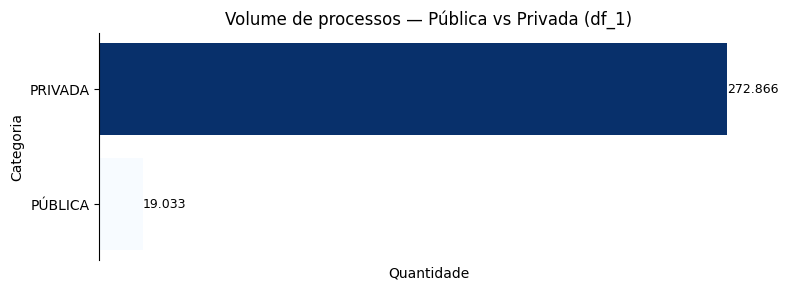

In [16]:
# Volume por tipo (pública/privada)
vol = tempo_pub_priv["quantidade_processos"]
bar_gradient_with_labels(
    labels=vol.index,
    values=vol.values,
    title="Volume de processos — Pública vs Privada (df_1)",
    xlabel="Quantidade",
    ylabel="Categoria",
    horizontal=True,
    figsize=(8,3)
)


## 10) Âmbito administrativo (Federal/Estadual/Municipal) — volume e tempo

In [17]:
tempo_tipo_ambito = (
    df_1.dropna(subset=["PUBLICA_PRIVADA", "AMBITO_ADMINISTRATIVO", "TEMPO_TRAMITACAO_DIAS"])
    .groupby(["PUBLICA_PRIVADA", "AMBITO_ADMINISTRATIVO"])["TEMPO_TRAMITACAO_DIAS"]
    .agg(quantidade_processos="count", tempo_medio_dias="mean", tempo_mediano_dias="median", tempo_total_dias="sum")
    .sort_values("quantidade_processos", ascending=False)
)
tempo_tipo_ambito


quantidade_processos  tempo_medio_dias  \
PUBLICA_PRIVADA AMBITO_ADMINISTRATIVO                                           
PRIVADA         FEDERAL                              271937        151.927652   
PÚBLICA         FEDERAL                               14945        348.017932   
                ESTADUAL                               4072         24.015226   
PRIVADA         ESTADUAL                                929         85.620022   
PÚBLICA         MUNICIPAL                                16          0.000000   

                                       tempo_mediano_dias  tempo_total_dias  
PUBLICA_PRIVADA AMBITO_ADMINISTRATIVO                                        
PRIVADA         FEDERAL                               0.0        41314750.0  
PÚBLICA         FEDERAL                               4.0         5201128.0  
                ESTADUAL                              0.0           97790.0  
PRIVADA         ESTADUAL                              0.0           79541.0  
PÚBLICA         MUNICIPAL                             0.0               0.0

## 11) Distribuição do tempo por âmbito administrativo (boxplot)

<Figure size 800x500 with 0 Axes>

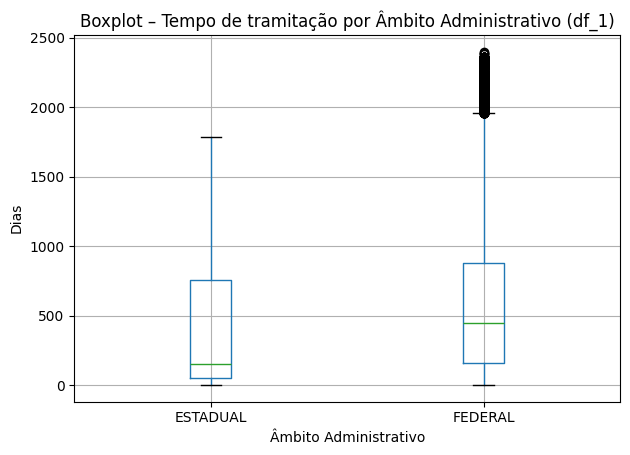

In [18]:
sub_box = df_1.dropna(subset=["AMBITO_ADMINISTRATIVO", "TEMPO_TRAMITACAO_DIAS"]).copy()
sub_box = sub_box[sub_box["TEMPO_TRAMITACAO_DIAS"] > 0]

plt.figure(figsize=(8,5))
sub_box.boxplot(column="TEMPO_TRAMITACAO_DIAS", by="AMBITO_ADMINISTRATIVO")
plt.title("Boxplot – Tempo de tramitação por Âmbito Administrativo (df_1)")
plt.suptitle("")
plt.xlabel("Âmbito Administrativo")
plt.ylabel("Dias")
plt.tight_layout()
plt.show()


## 12) Regressão exploratória (tempo de tramitação)

Modelo simples para entender sinais (não é modelo final):
- `IS_SEDE_EAD`
- `TEM_DIVERGENCIA_VAGAS`
- `ANO_DO_PROTOCOLO`

> O objetivo aqui é **interpretabilidade** (coeficientes) e um baseline.


endereco_divergente_flag,0.0,1.0
Modalidade_norm,,
EAD,56.976174,77.344117
PRESENCIAL,40.536008,22.209832
SEMIPRESENCIAL,2.487818,0.446051


is_sede_ead_flag,0.0,1.0
Modalidade_norm,,
EAD,62.001459,48.269921
PRESENCIAL,36.072483,44.996411
SEMIPRESENCIAL,1.926058,6.733668


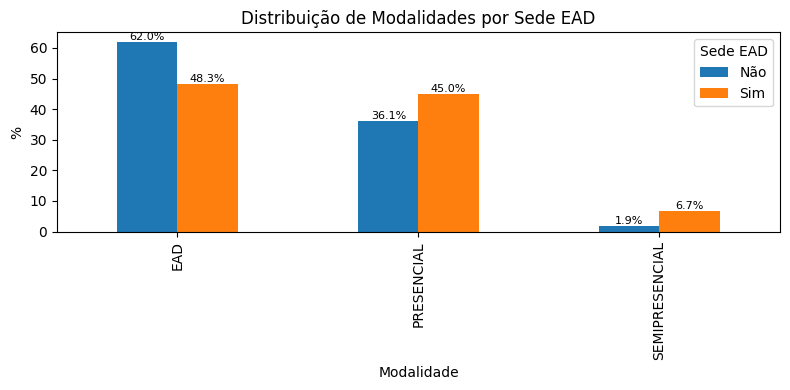

In [19]:

# -------------------------------------------------
# 1) Garantir Modalidade_norm (alias)
# -------------------------------------------------
if "Modalidade_norm" not in df_1.columns:
    if "MODALIDADE_NORM" in df_1.columns:
        df_1["Modalidade_norm"] = df_1["MODALIDADE_NORM"]
    elif "MODALIDADE" in df_1.columns:
        df_1["Modalidade_norm"] = df_1["MODALIDADE"].astype(str).str.strip().str.upper()
    else:
        df_1["Modalidade_norm"] = np.nan

# -------------------------------------------------
# 2) Flag de Endereço Divergente
# (coluna real do seu arquivo: ENDERECO_DIVERGENTE)
# -------------------------------------------------
if "ENDERECO_DIVERGENTE" in df_1.columns:
    s = df_1["ENDERECO_DIVERGENTE"].astype(str).str.strip().str.upper()
    df_1["endereco_divergente_flag"] = np.select(
        [
            s.isin(["SIM", "TRUE", "1", "VERDADEIRO", "T"]),
            s.isin(["NÃO", "NAO", "FALSE", "0", "FALSO", "F"]),
        ],
        [1, 0],
        default=np.nan
    )
else:
    df_1["endereco_divergente_flag"] = 0

# -------------------------------------------------
# 3) Garantir is_sede_ead como 0/1 (pra não dar erro no plot)
# -------------------------------------------------
if "is_sede_ead" in df_1.columns:
    raw = df_1["is_sede_ead"]
elif "IS_SEDE_EAD" in df_1.columns:
    raw = df_1["IS_SEDE_EAD"]
else:
    raw = pd.Series([np.nan] * len(df_1), index=df_1.index)

raw_str = raw.astype(str).str.strip().str.upper()

df_1["is_sede_ead_flag"] = np.select(
    [
        raw_str.isin(["SIM", "TRUE", "1", "VERDADEIRO", "T", "S"]),
        raw_str.isin(["NÃO", "NAO", "FALSE", "0", "FALSO", "F", "N"]),
    ],
    [1, 0],
    default=pd.to_numeric(raw, errors="coerce")
)

df_1.loc[~df_1["is_sede_ead_flag"].isin([0, 1]), "is_sede_ead_flag"] = np.nan

# -------------------------------------------------
# 4) Crosstabs (%)
# -------------------------------------------------
display(
    pd.crosstab(
        df_1["Modalidade_norm"],
        df_1["endereco_divergente_flag"],
        normalize="columns"
    ) * 100
)

display(
    pd.crosstab(
        df_1["Modalidade_norm"],
        df_1["is_sede_ead_flag"],
        normalize="columns"
    ) * 100
)

# -------------------------------------------------
# 5) Gráfico: Distribuição de Modalidades por Sede EAD
# (exclui NaN da sede antes de plotar)
# -------------------------------------------------
df_g = df_1.dropna(subset=["Modalidade_norm", "is_sede_ead_flag"]).copy()

tab = pd.crosstab(
    df_g["Modalidade_norm"],
    df_g["is_sede_ead_flag"],
    normalize="columns"
) * 100

# garantir numérico
tab = tab.apply(pd.to_numeric, errors="coerce")

ax = tab.plot(kind="bar", figsize=(8, 4))
plt.title("Distribuição de Modalidades por Sede EAD")
plt.xlabel("Modalidade")
plt.ylabel("%")

# legenda 0/1 -> Não/Sim (só para as colunas que existirem)
handles, labels = ax.get_legend_handles_labels()
labels_fmt = []
for l in labels:
    if l.strip() in ["0", "0.0"]:
        labels_fmt.append("Não")
    elif l.strip() in ["1", "1.0"]:
        labels_fmt.append("Sim")
    else:
        labels_fmt.append(l)
ax.legend(title="Sede EAD", labels=labels_fmt)

# ✅ Rótulos de dados (%)
for container in ax.containers:
    ax.bar_label(
        container,
        labels=[f"{v:.1f}%" if not np.isnan(v) else "" for v in container.datavalues],
        label_type="edge",
        fontsize=8
    )

plt.tight_layout()
plt.show()
